# Librerías

In [1]:
#!pip install pysqlite3
#!pip install scikit-lear

In [2]:
# Librerías estándar de Python
import os
import sys
import datetime
import sqlite3 as sql
from collections import Counter

# Librerías específicas de Google Colab
from google.colab import drive
from google.colab import files

# Librerías de manipulación de datos
import numpy as np
import pandas as pd

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Librerías estadísticas y de pruebas
import scipy.stats as stats
from scipy.stats import gaussian_kde

# Librerías de Machine Learning y Preprocesamiento
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


# Conectar con google drive


In [5]:
drive.flush_and_unmount() #Linea en caso de tener que desconectar el drive por algún tipo de falla

Drive not mounted, so nothing to flush and unmount.


In [6]:
drive.mount('/content/drive') #Linea para conectar al drive

Mounted at /content/drive


In [7]:
path="/content/drive/MyDrive/analitica 3/sistemas_recomendacion" ### ruta del repositorio en drive
os.chdir(path) ### volver la carpeta del repositorio directorio de trabajo
sys.path.append(path) ### agregarla al path, poder leer archivos de funciones propios como paquetes

In [8]:
import a_funciones as fn #Importar el documento de funciones para hacer uso de estas

# Base de datos

In [28]:
conn = sql.connect('/content/drive/MyDrive/analitica 3/sistemas_recomendacion/data/db_movies3') #Crear la conexión con la base de datos
cur = conn.cursor() #Creacion del cursos para realizar consultas dentro del mismo SQL

In [29]:
# Creación de cursor para  ejecutar consultas en la base de datos
# Visualizar las tablas contenidas en la base de datos
cur.execute("SELECT name FROM sqlite_master where type='table'")
cur.fetchall()

[('reco',),
 ('movies_final',),
 ('ratings_final',),
 ('df_explorado',),
 ('df_terminado',),
 ('df_catalogo',)]

## Carga de tabla en variable y visualización

In [30]:
cur.execute("SELECT * from df_explorado")
cur.fetchall()

[(1, 1, 4.0, 'Toy Story (1995)', 'Adventure', 1995.0),
 (1, 1, 4.0, 'Toy Story (1995)', 'Animation', 1995.0),
 (1, 1, 4.0, 'Toy Story (1995)', 'Children', 1995.0),
 (1, 1, 4.0, 'Toy Story (1995)', 'Comedy', 1995.0),
 (1, 1, 4.0, 'Toy Story (1995)', 'Fantasy', 1995.0),
 (1, 3, 4.0, 'Grumpier Old Men (1995)', 'Comedy', 1995.0),
 (1, 3, 4.0, 'Grumpier Old Men (1995)', 'Romance', 1995.0),
 (1, 6, 4.0, 'Heat (1995)', 'Action', 1995.0),
 (1, 6, 4.0, 'Heat (1995)', 'Crime', 1995.0),
 (1, 6, 4.0, 'Heat (1995)', 'Thriller', 1995.0),
 (1, 47, 5.0, 'Seven (a.k.a. Se7en) (1995)', 'Mystery', 1995.0),
 (1, 47, 5.0, 'Seven (a.k.a. Se7en) (1995)', 'Thriller', 1995.0),
 (1, 50, 5.0, 'Usual Suspects, The (1995)', 'Crime', 1995.0),
 (1, 50, 5.0, 'Usual Suspects, The (1995)', 'Mystery', 1995.0),
 (1, 50, 5.0, 'Usual Suspects, The (1995)', 'Thriller', 1995.0),
 (1, 70, 3.0, 'From Dusk Till Dawn (1996)', 'Action', 1996.0),
 (1, 70, 3.0, 'From Dusk Till Dawn (1996)', 'Comedy', 1996.0),
 (1, 70, 3.0, 'From Du

In [31]:
print("\nPrimeras 5 filas:")
df_final = pd.read_sql("SELECT * from df_explorado",conn)
df_final.head()


Primeras 5 filas:


,user_id,movie_id,rating,title,genres,year_movies
0,1,1,4.0,Toy Story (1995),Adventure,1995.0
1,1,1,4.0,Toy Story (1995),Animation,1995.0
2,1,1,4.0,Toy Story (1995),Children,1995.0
3,1,1,4.0,Toy Story (1995),Comedy,1995.0
4,1,1,4.0,Toy Story (1995),Fantasy,1995.0


# Limpieza

## Dumizado de variables

In [32]:
#Separar columna de generos
df_genres = pd.get_dummies(df_final['genres']).astype(int)

#Tomar los datos únicos de cada película sin la columna de géneros
df_movies = df_final.drop('genres', axis=1).drop_duplicates(subset=['user_id', 'movie_id', 'title'])

#Agregar información de géneros agrupando por movie_id
genres_by_movie = df_genres.groupby(df_final['movie_id']).max()

# Unir los dataframes
df_final2 = df_movies.set_index('movie_id').join(genres_by_movie).reset_index()

## Cambio de tipo de variable

In [33]:
# Convertir la columna 'year_movies' a tipo entero de 64 bits (int64)
df_final2['year_movies'] = df_final2['year_movies'].astype('int64')

# Convertir la columna 'movie_id' a tipo objeto
df_final2['movie_id'] = df_final2['movie_id'].astype('object')

# Convertir la columna 'user_id' a tipo objeto
df_final2['user_id'] = df_final2['user_id'].astype('object')

# Imprimir los tipos de datos actuales de todas las columnas del DataFrame
print(df_final2.dtypes)

movie_id        object
user_id         object
rating         float64
title           object
year_movies      int64
Action           int64
Adventure        int64
Animation        int64
Children         int64
Comedy           int64
Crime            int64
Documentary      int64
Drama            int64
Fantasy          int64
Film-Noir        int64
Horror           int64
IMAX             int64
Musical          int64
Mystery          int64
Romance          int64
Sci-Fi           int64
Thriller         int64
War              int64
Western          int64
dtype: object


Las comlumnas "user_id" y "movie_id" son convertidas en variables categóricas, pues estas solo funcionan como la identificación de los usuarios y las películas.

## Datos atípicos

Nuestra variable de mayor interés es el "rating" de cada película, por lo tanto solo se encontrarán los atípicos de esta.

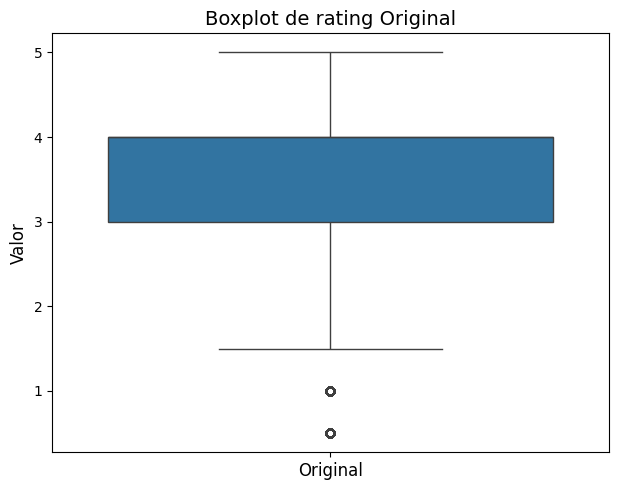

In [34]:
fn.visual_outliers(df_final2) #Visualización de los atipicos por medio de dos graficos histograma con linea KDE y boxplot

Los gráficos muestran que la distribución del rating tiene valores atípicos, evidenciados por puntos fuera del boxplot y colas en el histograma, correspondientes a calificaciones por debajo de 1.5 apróximadamente. La KDE sugiere una posible concentración de ratings en rangos específicos, con asimetría. Esto indica polarización en las opiniones o posibles errores en los datos, por lo que se hace necesario imputar estos valores extremos para su validación o tratamiento. Estos son imputador con la media.

In [35]:
fn.contar_outliers_iqr(df_final2) #Ver la cantidad de atipicos del dataframe o en este caso de la variable de interes que es rating

,Variable,Cantidad de Atípicos
0,rating,2811


In [36]:
#Imputar los valores atipicos de la variable ratings y visualizar como quedaria la tabla hasta este punto
df_final=fn.impute_outliers_with_mean(df_final2, 'rating')
df_final.head()

,movie_id,user_id,rating,title,year_movies,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,Toy Story (1995),1995,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,3,1,4.0,Grumpier Old Men (1995),1995,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,6,1,4.0,Heat (1995),1995,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,47,1,5.0,Seven (a.k.a. Se7en) (1995),1995,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,50,1,5.0,"Usual Suspects, The (1995)",1995,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [37]:
#Verifiquemos que si esten impuntando los atipicos de la variable rating
outliers_df = fn.contar_outliers_iqr(df_final2)
outliers_df

,Variable,Cantidad de Atípicos
0,rating,0


In [38]:
#Verificar si algun valor de rating esta por debajo de 0.5 o por encima de 5.0 y corregirlo
invalid_ratings = df_final2[(df_final2['rating'] < 0.5) | (df_final2['rating'] > 5.0)].shape[0]
print(f"Ratings inválidos: {invalid_ratings}")

Ratings inválidos: 0


En la base de datos todas las peliculas, sin excepcion, tienen su respectiva calificación

# Escalado de variables

Para un mejor entendimiento y manejo de la tabla, las variables son escaladas con MinMaxScaler. Se encuentra que df_final es la base de datos que será utilizada para la realización de los modelos, pues ya se encuentra preprocesada.

In [39]:
# Escalado de todo el data frame para facilitar su uso en la elaboración próxima de modelos de recomendación

# Seleccion de las variables a escalar
numcol = []
for col in df_final.columns:
    if df_final2[col].dtypes == "int64": #Seleccionar solo las variables con valores enteros
        numcol.append(col)

# Escalamiento de restar el minimo y dividir sobre el rango
scaler = MinMaxScaler()
for col in numcol:
    df_final2[[col]] = scaler.fit_transform(df_final2[[col]])

# Visualización de la base de datos escalada
df_final2

,movie_id,user_id,rating,title,year_movies,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,Toy Story (1995),0.705128,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,1,4.0,Grumpier Old Men (1995),0.705128,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,6,1,4.0,Heat (1995),0.705128,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,47,1,5.0,Seven (a.k.a. Se7en) (1995),0.705128,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,50,1,5.0,"Usual Suspects, The (1995)",0.705128,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79190,159093,610,3.0,Now You See Me 2 (2016),0.974359,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
79191,164179,610,5.0,Arrival (2016),0.974359,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
79192,166528,610,4.0,Rogue One: A Star Wars Story (2016),0.974359,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
79193,168250,610,5.0,Get Out (2017),0.987179,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Dataframes para modelos

En este caso el dataframe "df_terminado" y "ratings_final" seran los usados en los modelos de filtro colaborativo, así como en los modelos basados en consultas SQL. El hecho de que la información relevante ya se encuentre consolidada en estas tablas facilita significativamente su uso en ambos enfoques.

In [40]:
#Guardar conjunto de datos limpio y escalado
df_final2.to_sql('df_terminado', conn, if_exists='replace', index=False)

79195

In [41]:
#Verificar que el quedase bien guardado
cur.execute(""" select name from sqlite_master where type='table' """)
cur.fetchall()

[('reco',),
 ('movies_final',),
 ('ratings_final',),
 ('df_explorado',),
 ('df_catalogo',),
 ('df_terminado',)]

El "df_catalogo" sera usado en todos los demás modelos

In [42]:
df_terminado=pd.read_sql("SELECT * from df_terminado",conn)

In [43]:
# Eliminar columnas innecesarias
df_terminado2 = df_terminado.drop(columns=['user_id', 'rating'])

# Eliminar filas duplicadas según movie_id y tittle
df_terminado2 = df_terminado2.drop_duplicates(subset=['movie_id', 'title'])

In [44]:
# Calcular promedio de rating por película
promedios = df_terminado.groupby(['movie_id', 'title'])['rating'].mean().reset_index()
promedios.rename(columns={'rating': 'promedio_rating'}, inplace=True)

# Unir los promedios al dataframe filtrado
df_catalogo = pd.merge(df_terminado2, promedios, on=['movie_id', 'title'], how='left')

#Reordenar las columnas
cols = df_catalogo.columns.tolist()
cols_reordenadas = ['movie_id', 'title', 'promedio_rating'] + [col for col in cols if col not in ['movie_id', 'title', 'promedio_rating']]
df_catalogo = df_catalogo[cols_reordenadas]

# Mostrar resultado
df_catalogo


,movie_id,title,promedio_rating,year_movies,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),3.935248,0.705128,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,Grumpier Old Men (1995),3.467564,0.705128,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,6,Heat (1995),3.971356,0.705128,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,47,Seven (a.k.a. Se7en) (1995),4.031100,0.705128,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,50,"Usual Suspects, The (1995)",4.263023,0.705128,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100,85510,Sucker Punch (2011),3.125000,0.910256,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2101,93363,John Carter (2012),3.325302,0.923077,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2102,111364,Godzilla (2014),2.852179,0.948718,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2103,1327,"Amityville Horror, The (1979)",3.010443,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [45]:
#Guardar conjunto de datos limpio y escalado
df_catalogo.to_sql('df_catalogo', conn, if_exists='replace', index=False)

2105

In [46]:
#Verificar que el quedase bien guardado
cur.execute(""" select name from sqlite_master where type='table' """)
cur.fetchall()

[('reco',),
 ('movies_final',),
 ('ratings_final',),
 ('df_explorado',),
 ('df_terminado',),
 ('df_catalogo',)]